In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from  matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import seaborn as sn
import sys
from pathlib import Path
from tqdm import tqdm
import scipy

import torch.nn as nn
from torch import Tensor
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# import custom functions from src folder
module_path = str(Path.cwd() / "../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from SequentialNet import SequentialNet
from machine_learning import *
from util import *

In [2]:
def word_to_int(df):
    # Red = 0, blue = 1
    df["class"] = 0
    df_copy = df.copy()
    mask = df_copy["color"] == "blue"
    df.loc[mask, "class"] = 1
    return df


In [3]:
def plot_results(df, pred_key, ax, suptitle, error_key="None"):
    ax.set_title(suptitle)
    cmap = red_blue_cmap()
    if error_key == "None":
        sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue=pred_key, 
                    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                        palette=cmap, legend=False)
    else:
        sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue=pred_key, 
                       size=error_key, size_norm = (0.1, 0.2), sizes=(10, 200),
                        hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                        palette=cmap, legend=False)
    
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)
    ax.set_xlabel(r"x$_1$", fontsize=14)
    ax.set_ylabel(r"x$_2$", fontsize=14)

    ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
    ax.tick_params(which="major", length=6)
    ax.set_xticks([-20, 0, 20])
    ax.set_yticks([-20, 0, 20])
    ax.set_aspect('equal', adjustable='box')
    ax.minorticks_on()
    return ax


In [4]:
def predict_grid(model, x1_key, x2_key, device, dropoutropout:bool = False, nx:int = 100, n_MC:int = 100):
    x1_lim = 25
    x2_lim = 25
    x1 = np.linspace(-x1_lim, x1_lim, nx)
    x2 = np.linspace(-x2_lim, x2_lim, nx)
    xx1, xx2 = np.meshgrid(x1, x2)
    df = pd.DataFrame(columns = ["x1", "x2"], index = range(len(xx1.flatten())))
    df["x1"] = xx1.flatten()
    df["x2"] = xx2.flatten()
    df = cartesian_to_polar_df(df, "x1", "x2", "r_x", "a_x")

    X_gridtest = torch.Tensor(np.dstack((df[x1_key], df[x2_key]))).to(torch.float32)[0]
    Y_gridtest = torch.zeros(X_gridtest.shape)
    gridtest_dataset = torch.utils.data.TensorDataset(X_gridtest, Y_gridtest)
    if dropoutropout:
        mean_val, variance_val = mc_predictions(model, gridtest_dataset, 2**8, n_MC, 2, len(df))
        #Get average softmax score for blue
        df["Confidence_MC"] = mean_val[:,-1]
        df["Prediction_MC"] = np.argmax(mean_val, axis=-1).flatten()
        # Error is the same for both scores
        df["Std_MC"] = np.sqrt(variance_val[:,1])
    else:
        truth, logits = predict_classifier(model, gridtest_dataset, 2, 100, device)
        preds = torch.argmax(logits, dim=-1).flatten()
        df["Prediction"] = preds
        #Get softmax score for red
        df["Confidence"] = torch.softmax(logits, dim=-1)[:,1]
    return df

In [5]:
# Set up device
device = (
    "cuda:0"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device {torch.cuda.get_device_name(0)}")

Using cuda:0 device NVIDIA TITAN V


In [6]:
# Expertiment
def mc_dropout_experiment(X_train, Y_train, val_dataset, valfile, x1_key, x2_key, patience, n_train, p_MC, n_MC):
    
    n_df = max([len(n_train), len(p_MC), len(n_MC)])
    if (len(np.array(n_train)) < n_df):
        n_train = [n_train]*n_df
    if (len(np.array(p_MC)) < n_df):
        p_MC = [p_MC]*n_df
    if (len(np.array(n_MC)) < n_df):
        n_MC = [n_MC]*n_df

    val_data_dfs = [pd.read_csv(f"../data/{valfile}.csv") for i in range(len(n_df))]
    grid_dfs = [pd.DataFrame(columns = ["x1", "x2", "r_x", "a_x"], index = range(100*100)) for i in range(len(n_df))]
    
    for i in range(n_df):
        # Create datasets for pytorch
        train_dataset = torch.utils.data.TensorDataset(X_train[0:n_train[i]], Y_train[0:n_train[i]])

        # Create model
        model = SequentialNet(L=1024*2, n_hidden=5, activation="relu", in_channels=2, out_channels=2, p=p_MC[i]).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Train model
        training_results = train_classifier(model, train_dataset, 
                                val_dataset, batchsize=2**8, epochs = 80, 
                                device = device, optimizer = optimizer, early_stopping=patience)

        # Predict with just model
        truth, logits = predict_classifier(model, val_dataset, 2, 100, device)
        preds = torch.argmax(logits, dim=-1).flatten()
        val_data_dfs[i]["Prediction"] = preds
        val_data_dfs[i]["Truth"] = truth

        #Get softmax score for blue
        val_data_dfs[i]["Confidence"] = torch.softmax(logits, dim=-1)[:,1]
        
        #Predict grid without MC dropout
        grid_dfs[i] = predict_grid(model, x1_key, x2_key, device)

        # Predict with MC dropout
        mean_val, variance_val = mc_predictions(model, val_dataset, 2**8, n_MC[i], 2, len(val_dataset))
        val_data_dfs[i]["Prediction_MC"] = np.argmax(mean_val, axis=-1).flatten()
        val_data_dfs[i]["Confidence_MC"] = mean_val[:,-1]
        # Error is the same for both scores
        val_data_dfs[i]["Std_MC"] = np.sqrt(variance_val[:,0])

        # Predict grid with MC dropout
        grid_MC = predict_grid(model, x1_key, x2_key, device, dropoutropout=True)
        grid_dfs[i]["Prediction_MC"] = grid_MC["Prediction_MC"]
        grid_dfs[i]["Confidence_MC"] = grid_MC["Confidence_MC"]
        grid_dfs[i]["Std_MC"] = grid_MC["Std_MC"]
    return val_data_dfs, grid_dfs

In [7]:
# Machine learning options
x1_key = "x1"
x2_key = "x2"
n_data = [250, 500, 1000, 5000]
patience = 20
load_ensemble_values = True

#Data constants
R2 = 3
k_red = 7
k_blue = 3
R1_min = 6
scale = 1
vary_a1 = False
vary_R2 = False
p_red = 0.5
polar = True
tag = f'r2_{R2}_kr{k_red}_kb{k_blue}_r1min{R1_min}_s{scale}_vary_r2_{vary_R2}_vary_a1_{vary_a1}_pRed_{p_red}'

# Read files
train_n = 50000
trainfile = f"train_n_{train_n}_{tag}"
valfile = f"test_n_10000_{tag}"
truthfile = f"analytical_solution_x1_x2_grid_{tag}_nxMC_100_nr1MC_50"
testfile = "x1_x2_grid"

train_data = pd.read_csv(f"../data/{trainfile}.csv")
val_data = pd.read_csv(f"../data/{valfile}.csv")
test_data = pd.read_csv(f"../data/{testfile}.csv")
truth_data = pd.read_csv(f"../analytical/results/{truthfile}.csv")

#Correct analytical solution if class distribution is not equal
if p_red != 0.5:
    truth_data["P_red_and_x"] = truth_data["P_red_and_x"]*(p_red)/0.5
    truth_data["P_blue_and_x"] = truth_data["P_blue_and_x"]*(1-p_red)/0.5
    truth_data["P_x"] = truth_data["P_red_and_x"] + truth_data["P_blue_and_x"]
    truth_data["P_red_given_x"] = truth_data["P_red_and_x"]/truth_data["P_x"]
    truth_data["P_blue_given_x"] = truth_data["P_blue_and_x"]/truth_data["P_x"]

# Prepare data for pytorch
train_data = word_to_int(train_data)
val_data = word_to_int(val_data)

X_train = torch.Tensor(np.dstack((train_data[x1_key], train_data[x2_key]))).to(torch.float32)[0]
Y_train = label_maker(train_data["class"], 2)

X_val = torch.Tensor(np.dstack((val_data[x1_key], val_data[x2_key]))).to(torch.float32)[0]
Y_val = label_maker(val_data["class"], 2)

X_test = torch.Tensor(np.dstack((test_data[x1_key], test_data[x2_key]))).to(torch.float32)[0]
Y_test = torch.zeros(X_test.shape)

### Try different drop out rates

In [8]:

p_drop_out = [0.1, 0.2, 0.3, 0.4]
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
val_data_dfs_DO = [pd.read_csv(f"../data/{valfile}.csv") for i in range(len(p_drop_out))]
grid_dfs_DO = [pd.DataFrame(columns = ["x1", "x2", "r_x", "a_x"], index = range(100*100)) for i in range(len(p_drop_out))]
grid_MC_dfs_DO = [pd.DataFrame(columns = ["x1", "x2", "r_x", "a_x"], index = range(100*100)) for i in range(len(p_drop_out))]

for i in range(len(p_drop_out)):
    # Create datasets for pytorch
    train_dataset = torch.utils.data.TensorDataset(X_train[0:5000], Y_train[0:5000])

    # Create model
    model = SequentialNet(L=1024*2, n_hidden=5, activation="relu", in_channels=2, out_channels=2, p=p_drop_out[i]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train model
    training_results = train_classifier(model, train_dataset, 
                            val_dataset, batchsize=2**8, epochs = 80, 
                            device = device, optimizer = optimizer, early_stopping=patience)

    # Predict with just model
    truth, logits = predict_classifier(model, val_dataset, 2, 100, device)
    preds = torch.argmax(logits, dim=-1).flatten()
    val_data_dfs_DO[i]["Prediction"] = preds
    val_data_dfs_DO[i]["Truth"] = truth

    #Get softmax score for blue
    val_data_dfs_DO[i]["Confidence"] = torch.softmax(logits, dim=-1)[:,1]
    grid_dfs_DO[i] = predict_grid(model, x1_key, x2_key, device)

    # Predict with MC dropout
    mean_val, variance_val = mc_predictions(model, val_dataset, 2**8, 200, 2, len(val_dataset))
    val_data_dfs_DO[i]["Prediction_MC"] = np.argmax(mean_val, axis=-1).flatten()
    val_data_dfs_DO[i]["Confidence_MC"] = mean_val[:,-1]
    # Error is the same for both scores
    val_data_dfs_DO[i]["Std_MC"] = np.sqrt(variance_val[:,0])
    grid_MC_dfs_DO[i] = predict_grid(model, x1_key, x2_key, device, dropoutropout=True)
    

 76%|███████▋  | 61/80 [01:42<00:31,  1.68s/it]


Stopping training early at epoch 61


100%|██████████| 100/100 [00:00<00:00, 366.41it/s]


Starting MC dropout inference: 


100%|██████████| 200/200 [00:36<00:00,  5.44it/s]


Starting MC dropout inference: 


 55%|█████▌    | 44/80 [00:45<00:37,  1.03s/it]


Stopping training early at epoch 44


100%|██████████| 100/100 [00:00<00:00, 434.16it/s]


Starting MC dropout inference: 


100%|██████████| 200/200 [00:35<00:00,  5.60it/s]


Starting MC dropout inference: 


 96%|█████████▋| 77/80 [01:26<00:03,  1.13s/it]


Stopping training early at epoch 77


100%|██████████| 100/100 [00:00<00:00, 431.47it/s]


Starting MC dropout inference: 


100%|██████████| 200/200 [00:35<00:00,  5.65it/s]


Starting MC dropout inference: 


 70%|███████   | 56/80 [01:33<00:40,  1.67s/it]


Stopping training early at epoch 56


100%|██████████| 100/100 [00:00<00:00, 372.69it/s]


Starting MC dropout inference: 


100%|██████████| 200/200 [00:36<00:00,  5.50it/s]


Starting MC dropout inference: 


100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


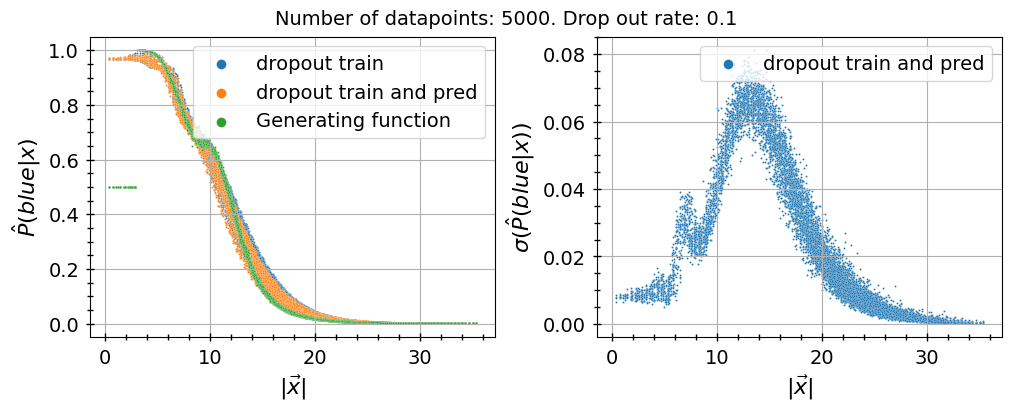

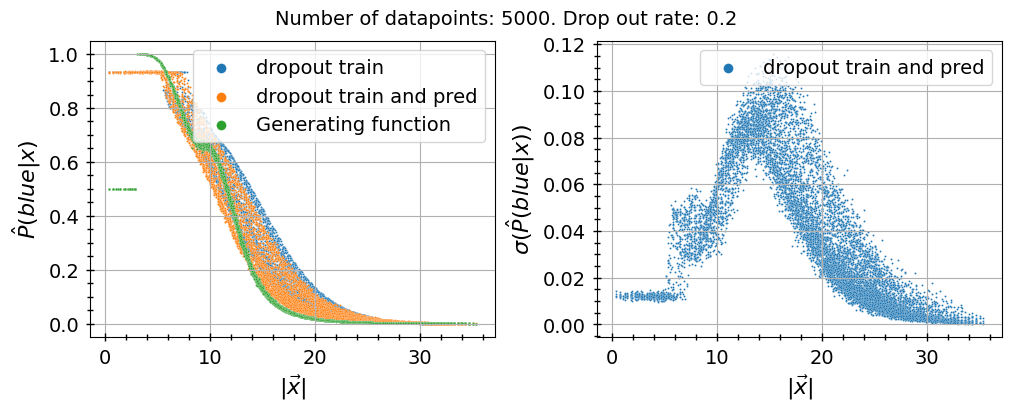

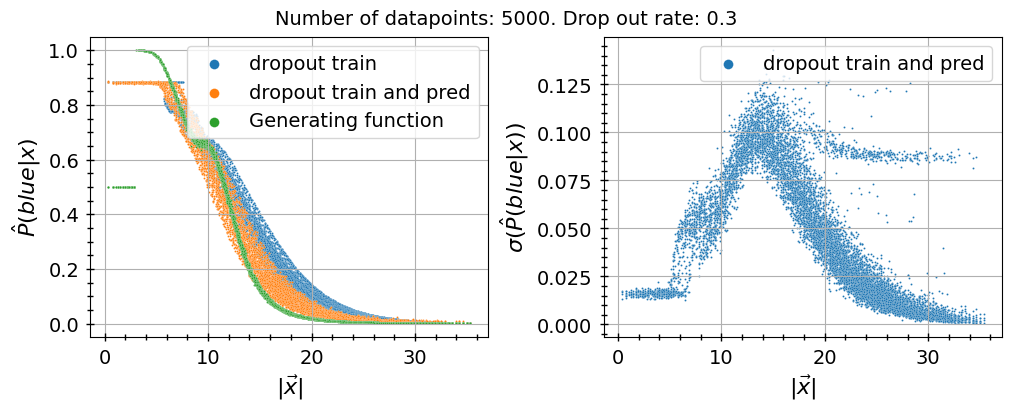

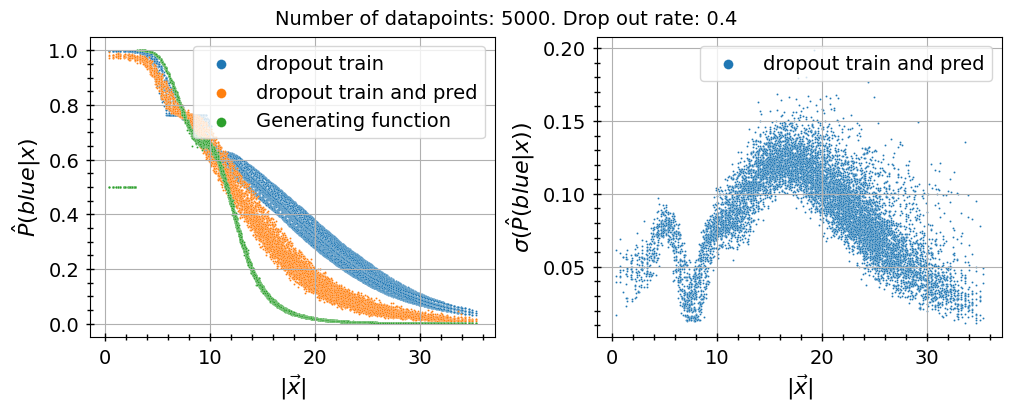

In [9]:
for i in range(len(p_drop_out)):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
    sn.scatterplot(grid_dfs_DO[i], x="r_x", y="Confidence", s=2, label="dropout train", ax = axs[0])
    sn.scatterplot(grid_MC_dfs_DO[i], x="r_x", y="Confidence_MC", s=2, label="dropout train and pred", ax = axs[0])
    sn.scatterplot(truth_data, x="r_x", y="P_blue_given_x", s=2, ax = axs[0], label="Generating function")
    
    axs[0].set_ylabel(r"$\hat{P}(blue|x)$", fontsize=16)

    sn.scatterplot(grid_MC_dfs_DO[i], x="r_x", y="Std_MC", s=2, label="dropout train and pred", ax = axs[1])

    axs[1].set_ylabel(r"$\sigma(\hat{P}(blue|x))$", fontsize=16)

    for ax in axs:
        ax.legend(markerscale=5, fontsize=14)
        ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
        ax.minorticks_on()
        ax.grid()
    fig.suptitle(f"Number of datapoints: {5000}. Drop out rate: {p_drop_out[i]}", fontsize=14)

### Standard deviation of MC dropout prediction

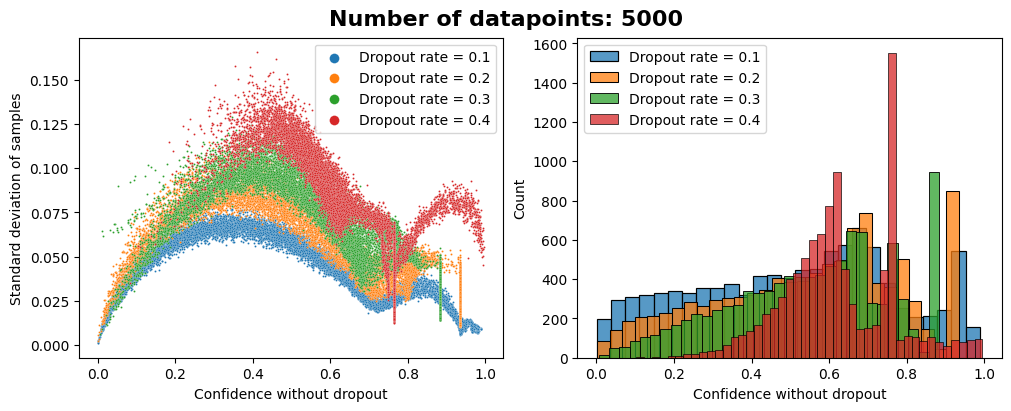

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
for i in range(len(p_drop_out)):
    sn.scatterplot(val_data_dfs_DO[i], x="Confidence", y="Std_MC", s=2, label=f"Dropout rate = {p_drop_out[i]}", ax = axs[0])
    axs[0].legend(markerscale=5)
    axs[0].set_ylabel("Standard deviation of samples")
    axs[0].set_xlabel("Confidence without dropout")
    sn.histplot(val_data_dfs_DO[i], x="Confidence", label=f"Dropout rate = {p_drop_out[i]}", ax = axs[1])
    axs[1].legend(markerscale=5)
    axs[1].set_ylabel("Count")
    axs[1].set_xlabel("Confidence without dropout")
    fig.suptitle(f"Number of datapoints: {5000}", size=16, fontweight="bold")

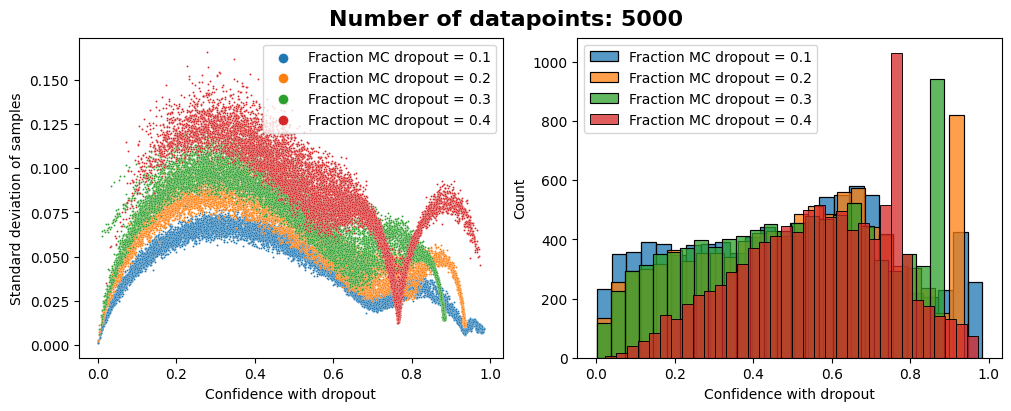

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
for i in range(len(p_drop_out)):
    sn.scatterplot(val_data_dfs_DO[i], x="Confidence_MC", y="Std_MC", s=2, label=f"Fraction MC dropout = {p_drop_out[i]}", ax = axs[0])
    axs[0].legend(markerscale=5)
    axs[0].set_ylabel("Standard deviation of samples")
    axs[0].set_xlabel("Confidence with dropout")
    sn.histplot(val_data_dfs_DO[i], x="Confidence_MC", label=f"Fraction MC dropout = {p_drop_out[i]}", ax = axs[1])
    axs[1].legend(markerscale=5)
    axs[1].set_ylabel("Count")
    axs[1].set_xlabel("Confidence with dropout")
    fig.suptitle(f"Number of datapoints: {5000}", size=16, fontweight="bold")

In [12]:

n_inference = [10, 100, 1000]
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
val_data_df_N = pd.read_csv(f"../data/{valfile}.csv")
grid_dfs_N = pd.DataFrame(columns = ["x1", "x2", "r_x", "a_x"], index = range(100*100))
grid_MC_dfs_N = pd.DataFrame(columns = ["x1", "x2", "r_x", "a_x"], index = range(100*100))


# Create datasets for pytorch
train_dataset = torch.utils.data.TensorDataset(X_train[0:5000], Y_train[0:5000])

# Create model
model = SequentialNet(L=1024*2, n_hidden=5, activation="relu", in_channels=2, out_channels=2, p=0.3).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train model
training_results = train_classifier(model, train_dataset, 
                        val_dataset, batchsize=2**8, epochs = 80, 
                        device = device, optimizer = optimizer)

# Predict with just model
truth, logits = predict_classifier(model, val_dataset, 2, 100, device)
preds = torch.argmax(logits, dim=-1).flatten()
val_data_df_N["Prediction"] = preds
val_data_df_N["Truth"] = truth

#Get softmax score for blue
val_data_df_N["Confidence"] = torch.softmax(logits, dim=-1)[:,1]
grid_df_N = predict_grid(model, x1_key, x2_key, device)


100%|██████████| 100/100 [00:00<00:00, 371.52it/s]


In [13]:

# Predict with MC dropout
for i in range(len(n_inference)):
    mean_val, variance_val = mc_predictions(model, val_dataset, 2**8, n_inference[i], 2, len(val_dataset))
    val_data_df_N[f"Prediction_MC_n{i}"] = np.argmax(mean_val, axis=-1).flatten()
    val_data_df_N[f"Confidence_MC_n{i}"] = mean_val[:,-1]
    # Error is the same for both scores
    val_data_df_N[f"Std_MC_n{i}"] = np.sqrt(variance_val[:,0])
    grid_MC = predict_grid(model, x1_key, x2_key, device, dropoutropout=True, n_MC=n_inference[i])
    grid_df_N[f"Prediction_MC_n{i}"] = grid_MC["Prediction_MC"]
    grid_df_N[f"Confidence_MC_n{i}"] = grid_MC["Confidence_MC"]
    grid_df_N[f"Std_MC_n{i}"] = grid_MC["Std_MC"]

Starting MC dropout inference: 


100%|██████████| 10/10 [00:01<00:00,  5.31it/s]


Starting MC dropout inference: 


100%|██████████| 10/10 [00:01<00:00,  5.31it/s]


Starting MC dropout inference: 


100%|██████████| 100/100 [00:19<00:00,  5.16it/s]


Starting MC dropout inference: 


100%|██████████| 100/100 [00:18<00:00,  5.49it/s]


Starting MC dropout inference: 


100%|██████████| 1000/1000 [03:35<00:00,  4.65it/s]


Starting MC dropout inference: 


100%|██████████| 1000/1000 [03:35<00:00,  4.64it/s]


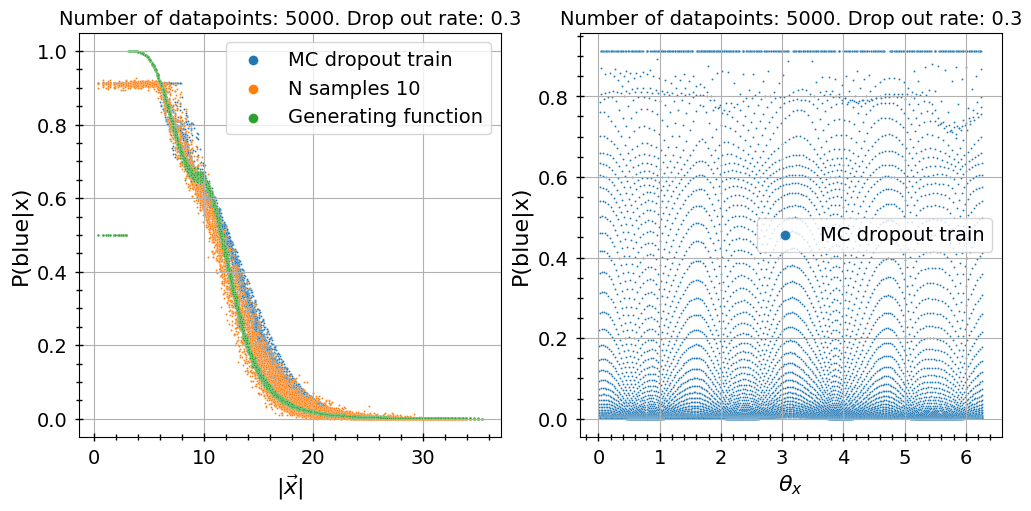

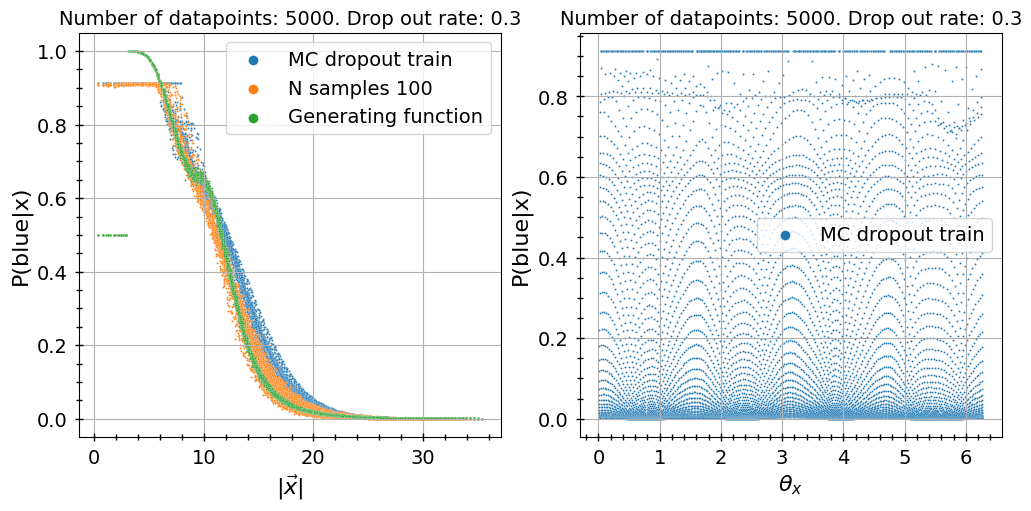

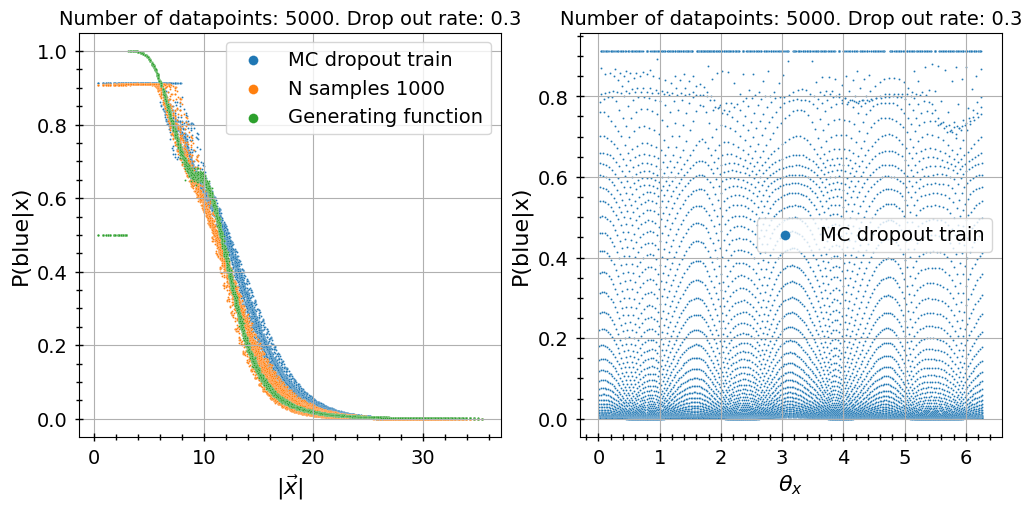

In [23]:

for i in range(len(n_inference)):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 5), layout="constrained")
    sn.scatterplot(grid_df_N, x="r_x", y="Confidence", s=2, label="MC dropout train", ax = axs[0])
    sn.scatterplot(grid_df_N, x="r_x", y=f"Confidence_MC_n{i}", s=2, label=f"N samples {n_inference[i]}", ax = axs[0])
    sn.scatterplot(truth_data, x="r_x", y="P_blue_given_x", s=2, ax = axs[0], label="Generating function")
    axs[0].set_title(f"Number of datapoints: {5000}. Drop out rate: {0.3}", fontsize=14)
    axs[0].set_xlabel(r"$|\vec{x}|$", fontsize=16)

    sn.scatterplot(grid_df_N, x="a_x", y="Confidence", s=2, label="MC dropout train", ax = axs[1])
    #sn.scatterplot(grid_df_N, x="a_x", y=f"Confidence_MC_n{i}", s=2, label=f"N samples {n_inference[i]}", ax = axs[1])
    #sn.scatterplot(truth_data, x="a_x", y="P_blue_given_x", s=2, ax = axs[1], label="Generating function")
    axs[1].set_title(f"Number of datapoints: {5000}. Drop out rate: {0.3}", fontsize=14)
    axs[1].set_xlabel(r"$\theta_x$", fontsize=16)

    for ax in axs:
        ax.legend(markerscale=5, fontsize=14)
        
        ax.set_ylabel(r"P(blue|x)", fontsize=16)
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
        ax.minorticks_on()
        ax.grid()

<Axes: xlabel='a_x', ylabel='r_x'>

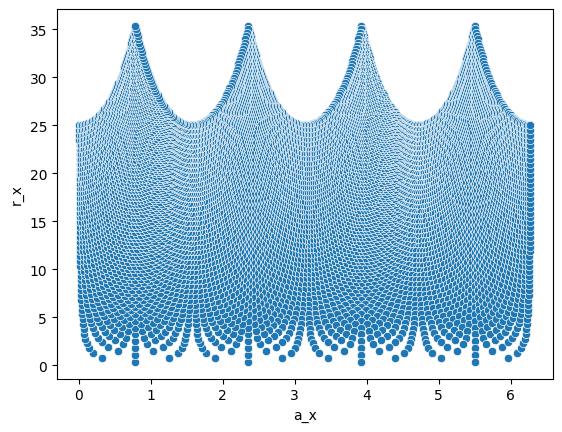

In [31]:
sn.scatterplot(grid_df_N, x="a_x", y="r_x")

<Axes: xlabel='a_x', ylabel='Confidence_MC_n2'>

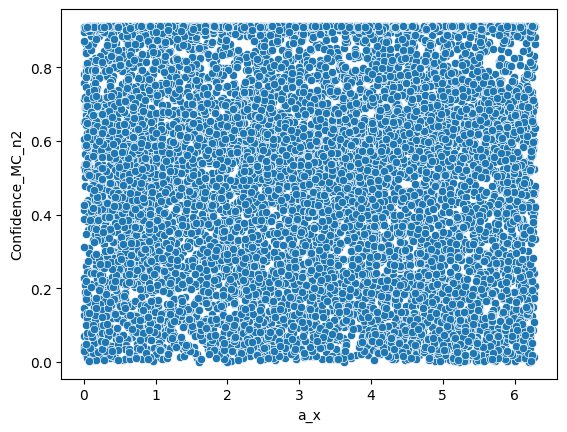

In [33]:
sn.scatterplot(val_data_df_N, x="a_x", y="Confidence_MC_n2")

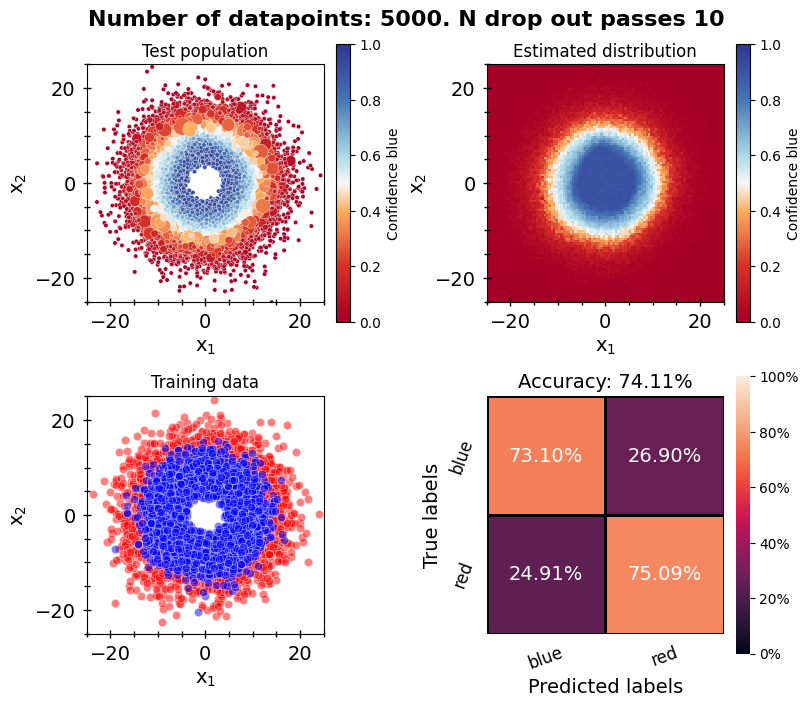

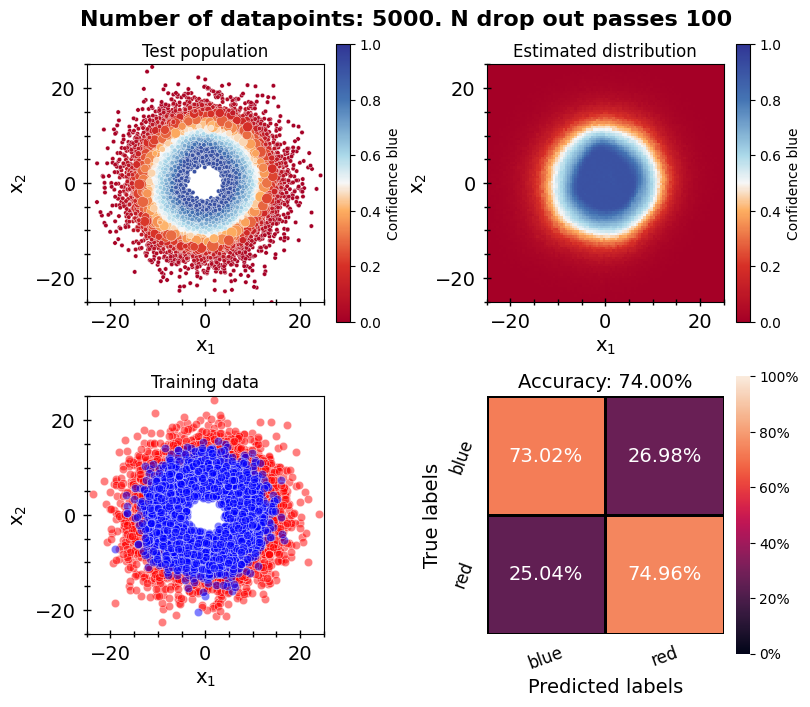

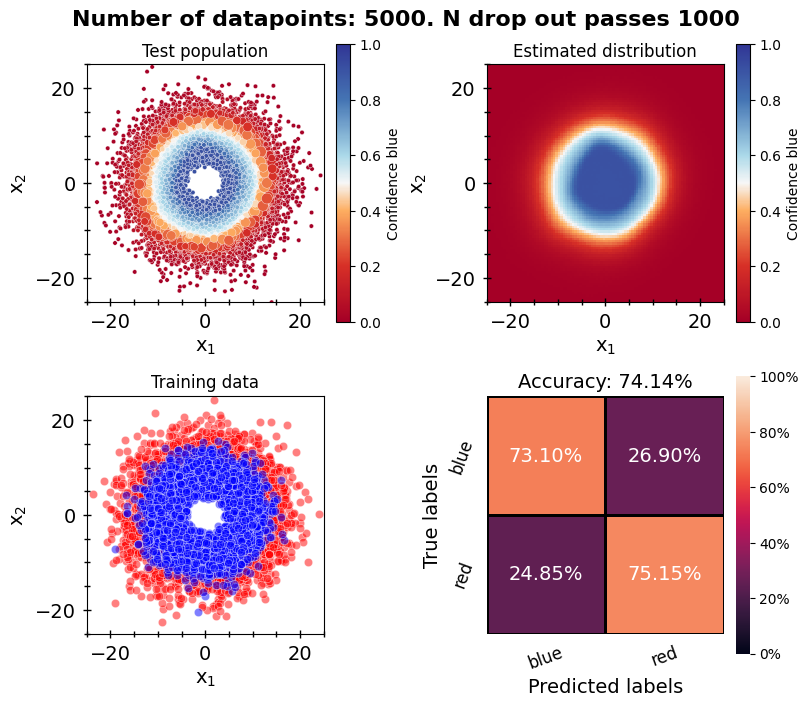

In [15]:
# Plot
for i in range(len(n_inference)):
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

    axs[0][0] = plot_results(val_data_df_N, f"Confidence_MC_n{i}", axs[0][0], "Test population", error_key=f"Std_MC_n{i}")
    axs[0][1] = plot_grid(grid_df_N, f"Confidence_MC_n{i}", axs[0][1], "Estimated distribution")
    axs[1][1] = plot_conf_matrix(val_data_df_N, "Truth", f"Prediction_MC_n{i}", ["blue", "red"], axs[1][1])
    axs[1][0] = plot_data(train_data[0:5000], axs[1][0], "Training data")

    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'Confidence blue', ax=axs[0][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'Confidence blue', ax=axs[0][1])

    fig.suptitle(f"Number of datapoints: {5000}. N drop out passes {n_inference[i]}", size=16, fontweight="bold")


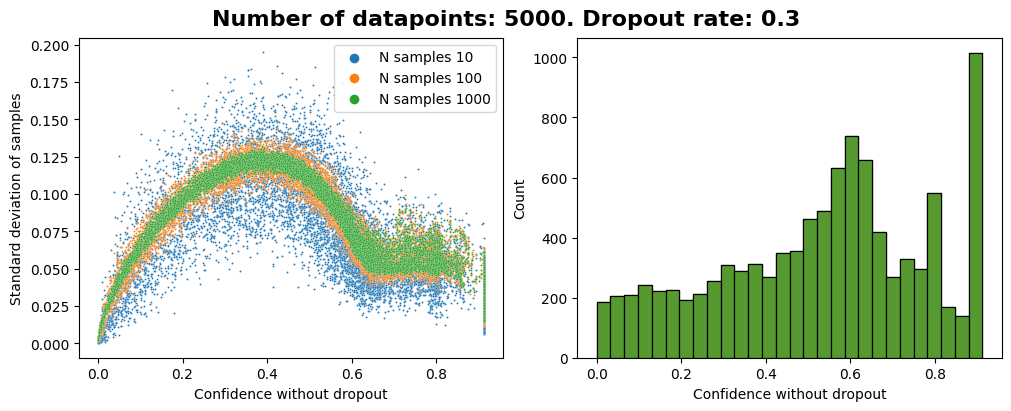

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
for i in range(len(n_inference)):
    sn.scatterplot(val_data_df_N, x="Confidence", y=f"Std_MC_n{i}", s=2, label=f"N samples {n_inference[i]}", ax = axs[0])
    axs[0].legend(markerscale=5)
    axs[0].set_ylabel("Standard deviation of samples")
    axs[0].set_xlabel("Confidence without dropout")

    sn.histplot(val_data_df_N, x="Confidence", ax = axs[1])
    axs[1].set_ylabel("Count")
    axs[1].set_xlabel("Confidence without dropout")
    fig.suptitle(f"Number of datapoints: {5000}. Dropout rate: 0.3", size=16, fontweight="bold")

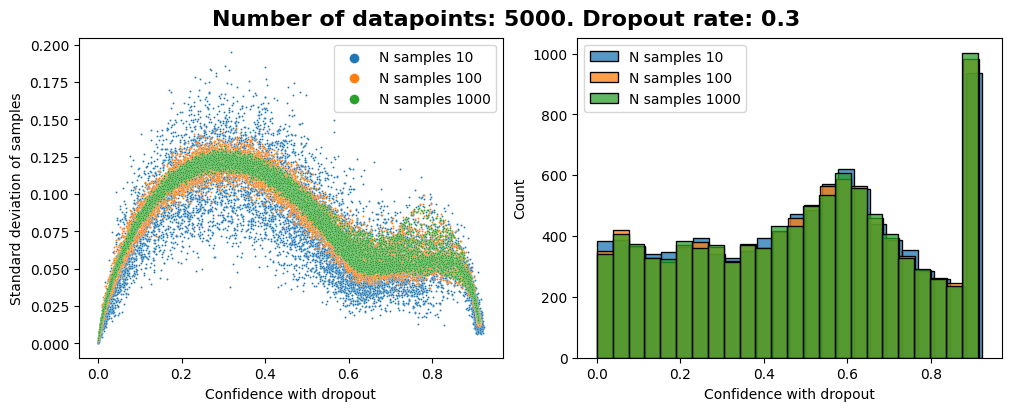

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
for i in range(len(n_inference)):
    sn.scatterplot(val_data_df_N, x=f"Confidence_MC_n{i}", y=f"Std_MC_n{i}", s=2, label=f"N samples {n_inference[i]}", ax = axs[0])
    axs[0].legend(markerscale=5)
    axs[0].set_ylabel("Standard deviation of samples")
    axs[0].set_xlabel("Confidence with dropout")

    sn.histplot(val_data_df_N, x=f"Confidence_MC_n{i}", label=f"N samples {n_inference[i]}", ax = axs[1])
    axs[1].set_ylabel("Count")
    axs[1].set_xlabel("Confidence with dropout")
    axs[1].legend()
    fig.suptitle(f"Number of datapoints: {5000}. Dropout rate: 0.3", size=16, fontweight="bold")